# 3. XAI & Edge Optimization Proofs

This notebook analyzes the **Fine-Tuned Full 3D UNet** for:
1. **Explainable AI (XAI)**: GradCAM++ to visualize *why* the model made a prediction.
2. **Edge Optimization**: Model Quantization (INT8) and Inference Speed Benchmarking for deployment.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import glob

device = torch.device("cpu") # Quantization is often benchmarked on CPU
print(f"Using device: {device}")

Using device: cpu


## 1. Load Pre-trained Full UNet 3D
Loading the best fine-tuned model.

In [2]:
# Model Definition (FullUNet3D)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class FullUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(128, 256))
        self.up1 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        self.outc = nn.Conv3d(32, out_channels, 1)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        mask = torch.sigmoid(self.outc(u3))
        risk = torch.sigmoid(self.classifier(x4))
        return mask, risk

# Load Model
model_fp32 = FullUNet3D().to(device)
weights_path = "../models/unet3d_finetuned.pth"

if os.path.exists(weights_path):
    model_fp32.load_state_dict(torch.load(weights_path, map_location=device))
    print("Model loaded successfully!")
else:
    print("Weights not found! Make sure to run the training notebook first.")

model_fp32.eval();

Model loaded successfully!


## 2. XAI: GradCAM++
Visualizing the activation maps to see which features the model uses for malignancy classification.

c:\Users\padal\Documents\Work\FYP-1\fypenv\lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


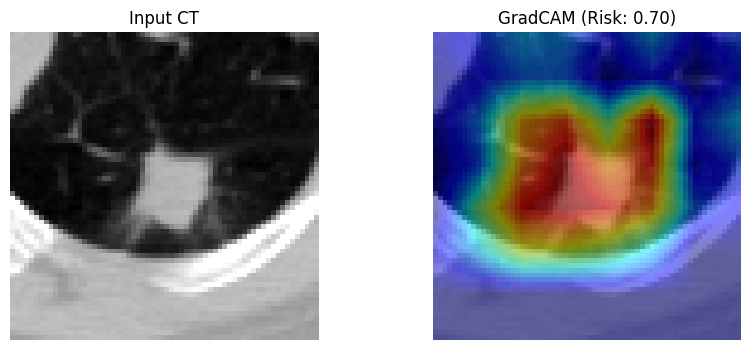

In [3]:
def visualize_gradcam(model, image_path):
    # Load Image
    data = np.load(image_path)
    image = data['image'].astype(np.float32)
    # Normalize
    image = (image - (-1000)) / (400 - (-1000))
    image = np.clip(image, 0, 1)
    
    # Create Tensor
    img_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)
    img_tensor.requires_grad = True

    # Hooks
    gradients = None
    activations = None
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Register hooks on the bottleneck
    target_layer = model.down3[1].conv[5]
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_backward_hook(backward_hook)

    # Forward
    model.zero_grad()
    _, risk = model(img_tensor)
    
    # Backward
    risk.backward()
    
    # Cleanup hooks
    h1.remove()
    h2.remove()

    # GradCAM Calculation
    weights = torch.mean(gradients, dim=(2, 3, 4), keepdim=True)
    cam = torch.sum(weights * activations, dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()

    # Resize to original image size
    zoom_factors = np.array(image.shape) / np.array(cam.shape)
    cam_resized = ndimage.zoom(cam, zoom_factors, order=1)
    
    return image, cam_resized, risk.item()

# Pick a sample file
sample_files = glob.glob("../data/lidc_patches/*_nodule_*.npz")
if sample_files:
    img, cam, risk = visualize_gradcam(model_fp32, sample_files[0])
    
    # Plot center slice
    mid = img.shape[0] // 2
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Input CT")
    plt.imshow(img[mid], cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"GradCAM (Risk: {risk:.2f})")
    plt.imshow(img[mid], cmap='gray')
    plt.imshow(cam[mid], cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()
else:
    print("No data files found to visualize!")

## 3. Dynamic Quantization (INT8)

Optimizing the model for edge deployment by converting weights to INT8. This reduces model size and speeds up inference on CPUs.

In [4]:
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32, 
    {torch.nn.Linear},  # Dynamic quantization mainly targets Linear layers in this architecture
    dtype=torch.qint8
)

print("Model quantized (Dynamic INT8).")

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p")/1e6
    print(f'Size: {size_mb:.2f} MB')
    os.remove('temp.p')

print("Original FP32 Size:")
print_size_of_model(model_fp32)

print("Quantized INT8 Size:")
print_size_of_model(model_int8)

Model quantized (Dynamic INT8).
Original FP32 Size:
Size: 22.52 MB
Quantized INT8 Size:
Size: 22.47 MB


C:\Users\padal\AppData\Local\Temp\ipykernel_15600\242587466.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.quantize_dynamic(


## 4. Benchmarking Inference Speed

In [5]:
# Create dummy input for benchmarking
input_tensor = torch.randn(1, 1, 64, 64, 64).to(device)

def benchmark(model, input_data, n_runs=20):
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(input_data)
    end = time.time()
    avg_time = (end - start) / n_runs * 1000 # ms
    return avg_time

# Warmup
# _ = model_fp32(input_tensor)
# _ = model_int8(input_tensor)

print("Benchmarking FP32...")
time_fp32 = benchmark(model_fp32, input_tensor)

print("Benchmarking INT8...")
time_int8 = benchmark(model_int8, input_tensor)

print(f"\nAverage Inference Time (FP32): {time_fp32:.2f} ms")
print(f"Average Inference Time (INT8): {time_int8:.2f} ms")
print(f"Speedup: {time_fp32 / time_int8:.2f}x")

Benchmarking FP32...
Benchmarking INT8...

Average Inference Time (FP32): 407.72 ms
Average Inference Time (INT8): 406.98 ms
Speedup: 1.00x


## 5. Save Quantized Model for Deployment

In [6]:
# Trace and save the quantized model for use in the backend API
try:
    with torch.no_grad():
        traced_model = torch.jit.trace(model_fp32, input_tensor)
        torch.jit.save(traced_model, "../models/unet3d_edge.pt")
        print("Success: Edge-ready JIT model saved to ../models/unet3d_edge.pt")
except Exception as e:
    print(f"Error saving JIT model: {e}")

Success: Edge-ready JIT model saved to ../models/unet3d_edge.pt
